# Logistic Regression - HR Analytics: Predicting Employee Attrition

## Problem Statement:

To predict whether employees are at risk for leaving the company, it will help in identification of employee attriton risks and to further provide necessary support to retain those employees or do preventive hiring to minimize the impact on the organisation.

## Importing Libraries

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

import scipy.stats as stats
import pandas_profiling

from sklearn.feature_selection import f_regression, RFE, SelectKBest, f_oneway
from sklearn.ensemble import RandomForestRegressor
from statsmodels.stats.outliers_influence import variance_inflation_factor
import statsmodels.formula.api as smf

from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn import metrics

# Supress Warnings

import warnings
warnings.filterwarnings('ignore')

## Importing Data

In [2]:
df = pd.read_csv('HR_comma_sep.csv')
df.head()

,satisfaction_level,last_evaluation,number_project,average_montly_hours,time_spend_company,Work_accident,left,promotion_last_5years,department,salary
0,0.38,0.53,2,157,3,0,1,0,sales,low
1,0.80,0.86,5,262,6,0,1,0,sales,medium
2,0.11,0.88,7,272,4,0,1,0,sales,medium
3,0.72,0.87,5,223,5,0,1,0,sales,low
4,0.37,0.52,2,159,3,0,1,0,sales,low


## Data Audit
### Getting Insights about the Dataset:

In [3]:
df.shape

(14999, 10)

In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14999 entries, 0 to 14998
Data columns (total 10 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   satisfaction_level     14999 non-null  float64
 1   last_evaluation        14999 non-null  float64
 2   number_project         14999 non-null  int64  
 3   average_montly_hours   14999 non-null  int64  
 4   time_spend_company     14999 non-null  int64  
 5   Work_accident          14999 non-null  int64  
 6   left                   14999 non-null  int64  
 7   promotion_last_5years  14999 non-null  int64  
 8   department             14999 non-null  object 
 9   salary                 14999 non-null  object 
dtypes: float64(2), int64(6), object(2)
memory usage: 1.1+ MB


In [5]:
df.describe()

,satisfaction_level,last_evaluation,number_project,average_montly_hours,time_spend_company,Work_accident,left,promotion_last_5years
count,14999.000000,14999.000000,14999.000000,14999.000000,14999.000000,14999.000000,14999.000000,14999.000000
mean,0.612834,0.716102,3.803054,201.050337,3.498233,0.144610,0.238083,0.021268
std,0.248631,0.171169,1.232592,49.943099,1.460136,0.351719,0.425924,0.144281
min,0.090000,0.360000,2.000000,96.000000,2.000000,0.000000,0.000000,0.000000
25%,0.440000,0.560000,3.000000,156.000000,3.000000,0.000000,0.000000,0.000000
50%,0.640000,0.720000,4.000000,200.000000,3.000000,0.000000,0.000000,0.000000
75%,0.820000,0.870000,5.000000,245.000000,4.000000,0.000000,0.000000,0.000000
max,1.000000,1.000000,7.000000,310.000000,10.000000,1.000000,1.000000,1.000000


In [6]:
report = pandas_profiling.ProfileReport(df)
report

Summarize dataset:   0%|          | 0/5 [00:00<?, ?it/s]

Generate report structure:   0%|          | 0/1 [00:00<?, ?it/s]

Render HTML:   0%|          | 0/1 [00:00<?, ?it/s]

### Data Cleaning:

In [7]:
# Checking for missing values in the data.

df.isna().sum()

satisfaction_level       0
last_evaluation          0
number_project           0
average_montly_hours     0
time_spend_company       0
Work_accident            0
left                     0
promotion_last_5years    0
department               0
salary                   0
dtype: int64

There are no NULL values in the dataset, hence it is clean.

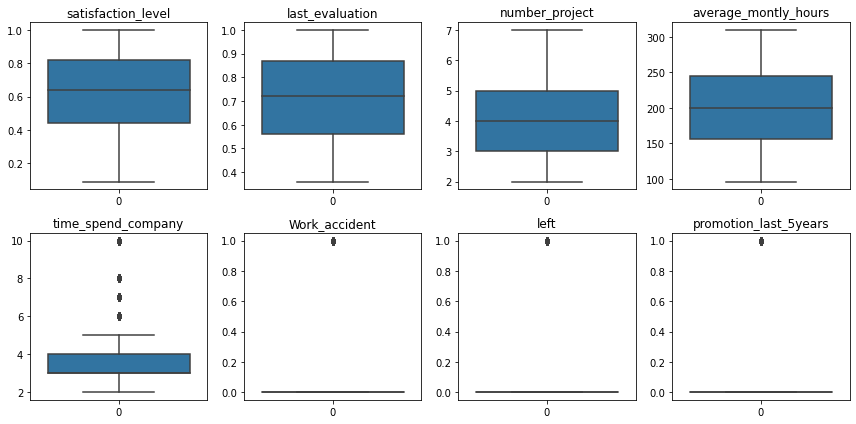

In [8]:
# Outlier Detection

fig, axs = plt.subplots(2,4, figsize = (12,6))

sns.boxplot(data = df['satisfaction_level'], ax = axs[0,0])
axs[0, 0].set_title('satisfaction_level')
sns.boxplot(data = df['last_evaluation'], ax = axs[0,1])
axs[0, 1].set_title('last_evaluation')
sns.boxplot(data = df['number_project'], ax = axs[0,2])
axs[0, 2].set_title('number_project')
sns.boxplot(data = df['average_montly_hours'], ax = axs[0,3])
axs[0, 3].set_title('average_montly_hours')
sns.boxplot(data = df['time_spend_company'], ax = axs[1,0])
axs[1, 0].set_title('time_spend_company')
sns.boxplot(data = df['Work_accident'], ax = axs[1,1])
axs[1, 1].set_title('Work_accident')
sns.boxplot(data = df['left'], ax = axs[1,2])
axs[1, 2].set_title('left')
sns.boxplot(data = df['promotion_last_5years'], ax = axs[1,3])
axs[1, 3].set_title('promotion_last_5years')

plt.tight_layout()

In [9]:
# Outlier Treatment

def outlier_treat(x):
    if(x.dtype == 'float64') or (x.dtype == 'int'):
            x = x.clip(lower = x.quantile(0.05), upper = x.quantile(0.95))
    else:
        x
    return x

In [10]:
df = df.apply(outlier_treat)

## Data Preparation
### Dummy Variable Creation:

In [11]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14999 entries, 0 to 14998
Data columns (total 10 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   satisfaction_level     14999 non-null  float64
 1   last_evaluation        14999 non-null  float64
 2   number_project         14999 non-null  int64  
 3   average_montly_hours   14999 non-null  int64  
 4   time_spend_company     14999 non-null  int64  
 5   Work_accident          14999 non-null  int64  
 6   left                   14999 non-null  int64  
 7   promotion_last_5years  14999 non-null  int64  
 8   department             14999 non-null  object 
 9   salary                 14999 non-null  object 
dtypes: float64(2), int64(6), object(2)
memory usage: 1.1+ MB


In [12]:
df1 = pd.get_dummies(df, columns = ['department', 'salary'], drop_first = True)
df1.head()

,satisfaction_level,last_evaluation,number_project,average_montly_hours,time_spend_company,Work_accident,left,promotion_last_5years,department_RandD,department_accounting,department_hr,department_management,department_marketing,department_product_mng,department_sales,department_support,department_technical,salary_low,salary_medium
0,0.38,0.53,2,157,3,0,1,0,0,0,0,0,0,0,1,0,0,1,0
1,0.80,0.86,5,262,6,0,1,0,0,0,0,0,0,0,1,0,0,0,1
2,0.11,0.88,7,272,4,0,1,0,0,0,0,0,0,0,1,0,0,0,1
3,0.72,0.87,5,223,5,0,1,0,0,0,0,0,0,0,1,0,0,1,0
4,0.37,0.52,2,159,3,0,1,0,0,0,0,0,0,0,1,0,0,1,0


### Calculating Coefficient of Variance for Variables:

In [13]:
df1.apply(lambda x: x.std()/x.mean())

satisfaction_level        0.401970
last_evaluation           0.233103
number_project            0.324106
average_montly_hours      0.248411
time_spend_company        0.417392
Work_accident             2.432193
left                      1.788977
promotion_last_5years     6.783943
department_RandD          4.249665
department_accounting     4.307743
department_hr             4.392907
department_management     4.775925
department_marketing      4.059858
department_product_mng    3.953435
department_sales          1.619605
department_support        2.393618
department_technical      2.124768
salary_low                1.024809
salary_medium             1.151937
dtype: float64

## Feature Engineering
### Performing Univariate Regression:

In [14]:
# Y variable is 'left' and remaining are X variables.    
# Appending all the values to a list called 'gini_uni'

gini_uni = []
for var in df1.columns.difference(['left']):
    m1 = smf.logit('left~'+var, data = df1).fit()
    pred_prob = m1.predict(df1)
    gini = 2*metrics.roc_auc_score(df1.left, pred_prob)-1
    gini_uni.append(gini)
    print("--------------------------------------------")

Optimization terminated successfully.
         Current function value: 0.534317
         Iterations 6
--------------------------------------------
Optimization terminated successfully.
         Current function value: 0.546317
         Iterations 5
--------------------------------------------
Optimization terminated successfully.
         Current function value: 0.547669
         Iterations 6
--------------------------------------------
Optimization terminated successfully.
         Current function value: 0.548747
         Iterations 5
--------------------------------------------
Optimization terminated successfully.
         Current function value: 0.548478
         Iterations 5
--------------------------------------------
Optimization terminated successfully.
         Current function value: 0.547682
         Iterations 6
--------------------------------------------
Optimization terminated successfully.
         Current function value: 0.548859
         Iterations 5
----------------

In [15]:
gini_uni

[0.12768307135603219,
 0.0629711232131196,
 0.024393847807764102,
 0.007861891974464186,
 0.014354932252353292,
 0.02168180027595623,
 0.00046854414969432767,
 0.006156426555576022,
 0.01041539755509202,
 0.008936326121822713,
 0.01816207094308786,
 0.007154701756370452,
 -0.025751574613174677,
 0.02093067408901117,
 0.15811048183324883,
 0.08000568398624353,
 0.49587712513601034,
 0.34665895994323637]

In [16]:
# Creating a dataframe 'univariate_results' with gini_uni values and features.

univariate_results = pd.concat([pd.DataFrame(df1.columns.difference(['left'])),pd.DataFrame(gini_uni)], axis = 1)
univariate_results.columns = ['var', 'gini']
univariate_results
univariate_results.sort_values(by = 'gini', ascending = False)

,var,gini
16,satisfaction_level,0.495877
17,time_spend_company,0.346659
14,salary_low,0.158110
0,Work_accident,0.127683
15,salary_medium,0.080006
1,average_montly_hours,0.062971
2,department_RandD,0.024394
5,department_management,0.021682
13,promotion_last_5years,0.020931
10,department_technical,0.018162


In [17]:
# Selecting the important variables by taking gini cut-off > 0.1

var_uni_reg = univariate_results[univariate_results.gini > 0.1]
var_uni_reg = list(var_uni_reg['var'])
var_uni_reg

['Work_accident', 'salary_low', 'satisfaction_level', 'time_spend_company']

### Separating X variables & Y variable:

In [18]:
X = df1[df1.columns.difference(['left'])]
X.head()

,Work_accident,average_montly_hours,department_RandD,department_accounting,department_hr,department_management,department_marketing,department_product_mng,department_sales,department_support,department_technical,last_evaluation,number_project,promotion_last_5years,salary_low,salary_medium,satisfaction_level,time_spend_company
0,0,157,0,0,0,0,0,0,1,0,0,0.53,2,0,1,0,0.38,3
1,0,262,0,0,0,0,0,0,1,0,0,0.86,5,0,0,1,0.80,6
2,0,272,0,0,0,0,0,0,1,0,0,0.88,7,0,0,1,0.11,4
3,0,223,0,0,0,0,0,0,1,0,0,0.87,5,0,1,0,0.72,5
4,0,159,0,0,0,0,0,0,1,0,0,0.52,2,0,1,0,0.37,3


In [19]:
Y = df1.left
Y.head()

0    1
1    1
2    1
3    1
4    1
Name: left, dtype: int64

### Performing RFE:

In [20]:
RFE_Model = RFE(estimator = RandomForestRegressor(), n_features_to_select = 10).fit(X,Y)

In [21]:
var_rfe = list(X.columns[RFE_Model.get_support()])
var_rfe

['average_montly_hours',
 'department_sales',
 'department_support',
 'department_technical',
 'last_evaluation',
 'number_project',
 'salary_low',
 'salary_medium',
 'satisfaction_level',
 'time_spend_company']

### Performing SelectKBest:

In [22]:
skb = SelectKBest(f_oneway, k = 10).fit(X,Y)
skb.get_support()

array([False,  True,  True,  True,  True,  True, False, False, False,
       False, False,  True,  True,  True, False, False,  True,  True])

In [23]:
var_skb = list(X.columns[skb.get_support()])
var_skb

['average_montly_hours',
 'department_RandD',
 'department_accounting',
 'department_hr',
 'department_management',
 'last_evaluation',
 'number_project',
 'promotion_last_5years',
 'satisfaction_level',
 'time_spend_company']

**Adding all the variable we got from Univariate Regression, RFE & SelectKBest**

In [24]:
var_uni_reg + var_rfe + var_skb

['Work_accident',
 'salary_low',
 'satisfaction_level',
 'time_spend_company',
 'average_montly_hours',
 'department_sales',
 'department_support',
 'department_technical',
 'last_evaluation',
 'number_project',
 'salary_low',
 'salary_medium',
 'satisfaction_level',
 'time_spend_company',
 'average_montly_hours',
 'department_RandD',
 'department_accounting',
 'department_hr',
 'department_management',
 'last_evaluation',
 'number_project',
 'promotion_last_5years',
 'satisfaction_level',
 'time_spend_company']

In [25]:
# Getting all the unique variables

list(set(var_uni_reg + list(var_rfe) + var_skb))

['last_evaluation',
 'average_montly_hours',
 'satisfaction_level',
 'department_accounting',
 'number_project',
 'salary_medium',
 'salary_low',
 'department_technical',
 'department_RandD',
 'department_hr',
 'Work_accident',
 'department_management',
 'department_support',
 'time_spend_company',
 'department_sales',
 'promotion_last_5years']

### Performing VIF:

In [26]:
# Assigning variables to final_list. 

final_list = list(set(var_uni_reg + list(var_rfe) + var_skb))
final_list

['last_evaluation',
 'average_montly_hours',
 'satisfaction_level',
 'department_accounting',
 'number_project',
 'salary_medium',
 'salary_low',
 'department_technical',
 'department_RandD',
 'department_hr',
 'Work_accident',
 'department_management',
 'department_support',
 'time_spend_company',
 'department_sales',
 'promotion_last_5years']

In [27]:
X[final_list]
X_final = X[final_list]
X_final.head()

,last_evaluation,average_montly_hours,satisfaction_level,department_accounting,number_project,salary_medium,salary_low,department_technical,department_RandD,department_hr,Work_accident,department_management,department_support,time_spend_company,department_sales,promotion_last_5years
0,0.53,157,0.38,0,2,0,1,0,0,0,0,0,0,3,1,0
1,0.86,262,0.80,0,5,1,0,0,0,0,0,0,0,6,1,0
2,0.88,272,0.11,0,7,1,0,0,0,0,0,0,0,4,1,0
3,0.87,223,0.72,0,5,0,1,0,0,0,0,0,0,5,1,0
4,0.52,159,0.37,0,2,0,1,0,0,0,0,0,0,3,1,0


In [28]:
# Checking for multicollinearity among the variables using VIF.

[variance_inflation_factor(X_final.values, i) for i in range(0, X_final.shape[1])]

[22.072154646266455,
 19.954720216497826,
 6.638615553041275,
 1.2280975082144798,
 14.024257677052045,
 5.157119628530301,
 5.690245515837687,
 1.8284017899434222,
 1.2412111849855272,
 1.2205262166314357,
 1.1737340707395123,
 1.2407537142824179,
 1.6820439526337831,
 6.806764535251092,
 2.260468101326342,
 1.0525055367002656]

In [29]:
# Creating an empty dataset and filling it with Features and their VIF values.

vif = pd.DataFrame()
vif['VIF'] = [variance_inflation_factor(X_final.values, i) for i in range(0, X_final.shape[1])]
vif['Feature'] = X_final.columns
vif
vif.sort_values(by = 'VIF', ascending = False)

,VIF,Feature
0,22.072155,last_evaluation
1,19.954720,average_montly_hours
4,14.024258,number_project
13,6.806765,time_spend_company
2,6.638616,satisfaction_level
6,5.690246,salary_low
5,5.157120,salary_medium
14,2.260468,department_sales
7,1.828402,department_technical
12,1.682044,department_support


In [30]:
# Dropping the variables one by one whose VIF value is > 10
# Dropping "last_evaluation"

X_final = X[final_list].drop(columns = ['last_evaluation'], axis = 1)
X_final.columns

Index(['average_montly_hours', 'satisfaction_level', 'department_accounting',
       'number_project', 'salary_medium', 'salary_low', 'department_technical',
       'department_RandD', 'department_hr', 'Work_accident',
       'department_management', 'department_support', 'time_spend_company',
       'department_sales', 'promotion_last_5years'],
      dtype='object')

In [31]:
# Re-running the vif code again.

vif = pd.DataFrame()
vif["VIF"] = [variance_inflation_factor(X_final.values, i) for i in range(0, X_final.shape[1])]
vif["Feature"] = X_final.columns
vif.sort_values(by = "VIF", ascending = False)

,VIF,Feature
0,17.622861,average_montly_hours
3,12.618913,number_project
12,6.621191,time_spend_company
1,5.989281,satisfaction_level
5,5.467873,salary_low
4,4.983399,salary_medium
13,2.252559,department_sales
6,1.819221,department_technical
11,1.672152,department_support
7,1.239614,department_RandD


In [32]:
# Dropping "average_montly_hours" variable and re-running the vif code.

X_final = X[final_list].drop(columns = ['last_evaluation', 'average_montly_hours'], axis = 1)

vif = pd.DataFrame()
vif["VIF"] = [variance_inflation_factor(X_final.values, i) for i in range(0, X_final.shape[1])]
vif["Feature"] = X_final.columns
vif.sort_values(by = "VIF", ascending = False)

,VIF,Feature
2,8.695066,number_project
11,6.371201,time_spend_company
0,5.527765,satisfaction_level
4,5.105745,salary_low
3,4.689665,salary_medium
12,2.226301,department_sales
5,1.800546,department_technical
10,1.658337,department_support
6,1.235353,department_RandD
9,1.229071,department_management


In [33]:
X_final.head()

,satisfaction_level,department_accounting,number_project,salary_medium,salary_low,department_technical,department_RandD,department_hr,Work_accident,department_management,department_support,time_spend_company,department_sales,promotion_last_5years
0,0.38,0,2,0,1,0,0,0,0,0,0,3,1,0
1,0.80,0,5,1,0,0,0,0,0,0,0,6,1,0
2,0.11,0,7,1,0,0,0,0,0,0,0,4,1,0
3,0.72,0,5,0,1,0,0,0,0,0,0,5,1,0
4,0.37,0,2,0,1,0,0,0,0,0,0,3,1,0


In [34]:
# Combining X variables with Y variable

df_final = pd.concat([X_final, Y], axis = 1)
df_final.head()

# This final data set will be used for Model Building.

,satisfaction_level,department_accounting,number_project,salary_medium,salary_low,department_technical,department_RandD,department_hr,Work_accident,department_management,department_support,time_spend_company,department_sales,promotion_last_5years,left
0,0.38,0,2,0,1,0,0,0,0,0,0,3,1,0,1
1,0.80,0,5,1,0,0,0,0,0,0,0,6,1,0,1
2,0.11,0,7,1,0,0,0,0,0,0,0,4,1,0,1
3,0.72,0,5,0,1,0,0,0,0,0,0,5,1,0,1
4,0.37,0,2,0,1,0,0,0,0,0,0,3,1,0,1


## Model Building
### Splitting the data into train and test:

In [35]:
train, test = train_test_split(df_final, test_size = 0.3, random_state = 123)

In [36]:
train.head()

,satisfaction_level,department_accounting,number_project,salary_medium,salary_low,department_technical,department_RandD,department_hr,Work_accident,department_management,department_support,time_spend_company,department_sales,promotion_last_5years,left
5242,0.76,0,3,1,0,0,0,0,0,0,1,2,0,0,0
12674,0.46,0,2,0,1,0,0,0,0,0,0,3,0,0,1
6924,0.36,0,3,0,1,0,0,0,0,0,1,5,0,0,0
12595,0.11,0,5,0,1,0,0,0,0,0,0,4,0,0,1
13482,0.58,0,3,1,0,0,0,0,0,1,0,7,0,1,0


In [37]:
test.head()

,satisfaction_level,department_accounting,number_project,salary_medium,salary_low,department_technical,department_RandD,department_hr,Work_accident,department_management,department_support,time_spend_company,department_sales,promotion_last_5years,left
6958,0.54,0,3,0,0,0,0,0,0,0,0,2,1,0,0
7534,0.72,0,3,0,1,0,0,0,1,0,1,4,0,0,0
2975,0.95,0,3,0,1,0,1,0,0,0,0,2,0,0,0
3903,0.78,0,3,0,1,0,0,0,0,0,0,2,1,0,0
8437,0.60,0,3,0,1,1,0,0,1,0,0,4,0,0,0


In [38]:
train.shape

(10499, 15)

In [39]:
test.shape

(4500, 15)

In [40]:
# The equation for the model will be:

eqn = 'left ~ ' + ' + '.join(train.columns.difference(['left']))
eqn

'left ~ Work_accident + department_RandD + department_accounting + department_hr + department_management + department_sales + department_support + department_technical + number_project + promotion_last_5years + salary_low + salary_medium + satisfaction_level + time_spend_company'

In [41]:
# Passing the eqn in our model.

model_final = smf.logit(eqn, data = train).fit()

Optimization terminated successfully.
         Current function value: 0.433308
         Iterations 7


In [42]:
print(model_final.summary())

                           Logit Regression Results                           
Dep. Variable:                   left   No. Observations:                10499
Model:                          Logit   Df Residuals:                    10484
Method:                           MLE   Df Model:                           14
Date:                Fri, 08 Sep 2023   Pseudo R-squ.:                  0.2106
Time:                        13:35:05   Log-Likelihood:                -4549.3
converged:                       True   LL-Null:                       -5762.9
Covariance Type:            nonrobust   LLR p-value:                     0.000
                            coef    std err          z      P>|z|      [0.025      0.975]
-----------------------------------------------------------------------------------------
Intercept                -0.8585      0.197     -4.353      0.000      -1.245      -0.472
Work_accident            -1.5749      0.108    -14.555      0.000      -1.787      -1.363
departme

In [43]:
# Dropping the variables with high p-value, which are insignificant and re-running the model
# Dropping 'department_accounting' variable

eqn = 'left ~ ' + ' + '.join(train.columns.difference(['left', 'department_accounting']))

model_final = smf.logit(eqn, data = train).fit()
print(model_final.summary())

Optimization terminated successfully.
         Current function value: 0.433384
         Iterations 7
                           Logit Regression Results                           
Dep. Variable:                   left   No. Observations:                10499
Model:                          Logit   Df Residuals:                    10485
Method:                           MLE   Df Model:                           13
Date:                Fri, 08 Sep 2023   Pseudo R-squ.:                  0.2105
Time:                        13:35:13   Log-Likelihood:                -4550.1
converged:                       True   LL-Null:                       -5762.9
Covariance Type:            nonrobust   LLR p-value:                     0.000
                            coef    std err          z      P>|z|      [0.025      0.975]
-----------------------------------------------------------------------------------------
Intercept                -0.8218      0.195     -4.214      0.000      -1.204      -0.

In [44]:
# Dropping 'department_sales' variable

eqn = 'left ~ ' + ' + '.join(train.columns.difference(['left', 'department_accounting', 'department_sales']))

model_final = smf.logit(eqn, data = train).fit()
print(model_final.summary())

Optimization terminated successfully.
         Current function value: 0.433422
         Iterations 7
                           Logit Regression Results                           
Dep. Variable:                   left   No. Observations:                10499
Model:                          Logit   Df Residuals:                    10486
Method:                           MLE   Df Model:                           12
Date:                Fri, 08 Sep 2023   Pseudo R-squ.:                  0.2104
Time:                        13:35:17   Log-Likelihood:                -4550.5
converged:                       True   LL-Null:                       -5762.9
Covariance Type:            nonrobust   LLR p-value:                     0.000
                            coef    std err          z      P>|z|      [0.025      0.975]
-----------------------------------------------------------------------------------------
Intercept                -0.7920      0.192     -4.124      0.000      -1.168      -0.

In [45]:
# Dropping 'department_support' variable

eqn = 'left ~ ' + ' + '.join(train.columns.difference(['left', 'department_accounting', 'department_sales', 'department_support']))

model_final = smf.logit(eqn, data = train).fit()
print(model_final.summary())

Optimization terminated successfully.
         Current function value: 0.433455
         Iterations 7
                           Logit Regression Results                           
Dep. Variable:                   left   No. Observations:                10499
Model:                          Logit   Df Residuals:                    10487
Method:                           MLE   Df Model:                           11
Date:                Fri, 08 Sep 2023   Pseudo R-squ.:                  0.2103
Time:                        13:35:28   Log-Likelihood:                -4550.8
converged:                       True   LL-Null:                       -5762.9
Covariance Type:            nonrobust   LLR p-value:                     0.000
                            coef    std err          z      P>|z|      [0.025      0.975]
-----------------------------------------------------------------------------------------
Intercept                -0.7776      0.191     -4.066      0.000      -1.152      -0.

**This is our model.**

### Calculating Probabilities 

In [46]:
# Using predict function on train data and test data.

prob_train = model_final.predict(train)
prob_test = model_final.predict(test)

In [47]:
# AUC_Score for train & test

print('auc_score_train:', metrics.roc_auc_score(train.left, prob_train))
print('auc_score_test:', metrics.roc_auc_score(test.left, prob_test))

# Gini for train & test

print('gini_train:', 2*metrics.roc_auc_score(train.left, prob_train)-1)
print('gini_test:', 2*metrics.roc_auc_score(test.left, prob_test)-1)


auc_score_train: 0.8125627703462932
auc_score_test: 0.8110228051558914
gini_train: 0.6251255406925864
gini_test: 0.6220456103117828


In [48]:
# calculating the probabilities for train & test data,

train['prob'] = model_final.predict(train)
test['prob'] = model_final.predict(test)

### Finding Threshold Value

In [49]:
train.left.mean()

0.23811791599199925

In [50]:
# calculating predicted value for train & test data

train['pred_left'] = np.where(train.prob > 0.23811791599199925, 1, 0)
test['pred_left'] = np.where(test.prob > 0.23811791599199925, 1, 0)

In [52]:
# Classification Report for train data

print(metrics.classification_report(train.left, train.pred_left))

              precision    recall  f1-score   support

           0       0.89      0.74      0.81      7999
           1       0.46      0.72      0.56      2500

    accuracy                           0.73     10499
   macro avg       0.68      0.73      0.69     10499
weighted avg       0.79      0.73      0.75     10499

              precision    recall  f1-score   support

           0       0.89      0.74      0.81      3429
           1       0.46      0.72      0.56      1071

    accuracy                           0.73      4500
   macro avg       0.68      0.73      0.69      4500
weighted avg       0.79      0.73      0.75      4500



In [54]:
# Classification Report for test data

print(metrics.classification_report(test.left, test.pred_left))

              precision    recall  f1-score   support

           0       0.87      0.54      0.67      3429
           1       0.34      0.74      0.46      1071

    accuracy                           0.59      4500
   macro avg       0.60      0.64      0.56      4500
weighted avg       0.74      0.59      0.62      4500



In [53]:
# Confusion Matrix for train data

metrics.confusion_matrix(train.left, train.pred_left)

array([[5910, 2089],
       [ 699, 1801]], dtype=int64)

In [54]:
# Confusion Matrix for test data

metrics.confusion_matrix(test.left, test.pred_left)

array([[2525,  904],
       [ 298,  773]], dtype=int64)

### Decile Analysis

In [56]:
train.prob

5242     0.160741
12674    0.300772
6924     0.423689
12595    0.359937
13482    0.107693
           ...   
5218     0.246615
12252    0.300772
1346     0.490087
11646    0.422437
3582     0.138413
Name: prob, Length: 10499, dtype: float64

In [56]:
# Adding deciles to train & test data by dividing the train & test data probabilities into 10 equal parts using qcut:

train['decile'] = pd.qcut(train.prob, 10, labels = False, duplicates='drop')
test['decile'] = pd.qcut(test.prob, 10, labels = False, duplicates = 'drop')

In [57]:
# Calculating the no. of actual 1’s in each decile:

train[['decile', 'left']].groupby('decile').agg(sum)

,left
decile,
0,26
1,35
2,23
3,119
4,204
5,230
6,177
7,386
8,712


In [58]:
# Calculating the no. of actual 1’s in each decile:

test[['decile', 'left']].groupby('decile').agg(sum)

,left
decile,
0,7
1,15
2,14
3,52
4,97
5,92
6,69
7,171
8,298


In [59]:
# Finding no. of employees who stayed

train['stayed'] = 1 - train.left
test['stayed'] = 1 - test.left

In [59]:
train.head()

,satisfaction_level,department_accounting,number_project,salary_medium,salary_low,department_technical,department_RandD,department_hr,Work_accident,department_management,department_support,time_spend_company,department_sales,promotion_last_5years,left,prob,pred_left,decile
5242,0.76,0,3,1,0,0,0,0,0,0,1,2,0,0,0,0.089458,0,2
12674,0.46,0,2,0,1,0,0,0,0,0,0,3,0,0,1,0.455868,1,8
6924,0.36,0,3,0,1,0,0,0,0,0,1,5,0,0,0,0.646447,1,9
12595,0.11,0,5,0,1,0,0,0,0,0,0,4,0,0,1,0.726893,1,9
13482,0.58,0,3,1,0,0,0,0,0,1,0,7,0,1,0,0.116718,0,3


In [60]:
test.head()

,satisfaction_level,department_accounting,number_project,salary_medium,salary_low,department_technical,department_RandD,department_hr,Work_accident,department_management,department_support,time_spend_company,department_sales,promotion_last_5years,left,prob,pred_left,decile
6958,0.54,0,3,0,0,0,0,0,0,0,0,2,1,0,0,0.055532,0,1
7534,0.72,0,3,0,1,0,0,0,1,0,1,4,0,0,0,0.065408,0,2
2975,0.95,0,3,0,1,0,1,0,0,0,0,2,0,0,0,0.044860,0,1
3903,0.78,0,3,0,1,0,0,0,0,0,0,2,1,0,0,0.133364,0,4
8437,0.60,0,3,0,1,1,0,0,1,0,0,4,0,0,0,0.114298,0,3


In [61]:
# Calculating each decile wise the min & max probabilities:

decile_results_train = train.groupby(['decile']).agg(min_prob = ('prob', 'min'),
                              max_prob = ('prob', 'max'),
                              No_left = ('left', 'sum'),
                              No_stayed = ('stayed', 'sum'), 
                              total = ('left', 'count'))

decile_results_test = test.groupby(['decile']).agg(min_prob = ('prob', 'min'),
                              max_prob = ('prob', 'max'),
                              No_left = ('left', 'sum'),
                              No_stayed = ('stayed', 'sum'), 
                              total = ('left', 'count'))


In [62]:
decile_results_train

,min_prob,max_prob,No_left,No_stayed,total
decile,,,,,
0,0.001765,0.061955,46,1029,1075
1,0.062325,0.111546,111,924,1035
2,0.111823,0.174306,75,986,1061
3,0.175613,0.200249,236,985,1221
4,0.201420,0.246615,239,704,943
5,0.247570,0.267910,139,961,1100
6,0.268883,0.300772,630,975,1605
7,0.301226,0.323604,195,354,549
8,0.324077,0.384789,407,574,981


In [63]:
decile_results_test

,min_prob,max_prob,No_left,No_stayed,total
decile,,,,,
0,0.001765,0.061955,27,456,483
1,0.062325,0.106583,44,401,445
2,0.107083,0.169797,39,391,430
3,0.173569,0.200249,112,451,563
4,0.203274,0.246615,107,284,391
5,0.247570,0.267910,52,394,446
6,0.268883,0.300772,252,409,661
7,0.301226,0.323604,80,150,230
8,0.358756,0.384789,179,290,469


### ROC Curve:

In [64]:
roc_curve = pd.DataFrame(metrics.roc_curve(train.left, prob_train)).T
roc_curve.columns = ['fpr', 'tpr', 'cut-offs']

In [65]:
roc_curve.head()

,fpr,tpr,cut-offs
0,0.000000,0.0,1.757435
1,0.001125,0.0,0.757435
2,0.003750,0.0,0.737362
3,0.004001,0.0,0.646271
4,0.004751,0.0,0.645098


auc_score_train: 0.7129612201525191


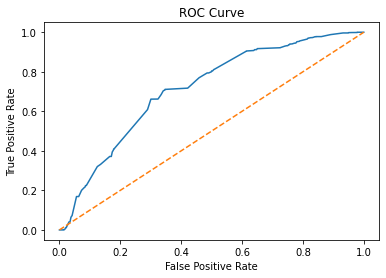

In [66]:
# Plotting ROC_Curve

plt.subplots(1, figsize=(6,4))
plt.title('ROC Curve')
plt.plot(roc_curve.fpr, roc_curve.tpr)
plt.plot([0, 1], ls="--")
#plt.plot([0, 0], [1, 0] , c=".7"), plt.plot([1, 1] , c=".7")
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
print('auc_score_train:',metrics.roc_auc_score(train.left, prob_train))
plt.show()